In [1]:
!lshw -class processor

  *-cpu                     
       product: Intel(R) Xeon(R) W-2295 CPU @ 3.00GHz
       vendor: Intel Corp.
       physical id: 1
       bus info: cpu@0
       size: 3424MHz
       capacity: 4600MHz
       width: 64 bits
       capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp x86-64 constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single intel_ppin ssbd mba ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb intel_pt avx512cd avx512bw avx512vl xs

In [2]:
!nvidia-smi

Fri Jun 26 01:39:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 30%   44C    P8     6W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 23%   38C    P8     2W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import mxnet as mx
import numpy as np
import os, time, shutil

import matplotlib.pyplot as plt

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

In [4]:
mx.context.num_gpus()

4

In [5]:
classes = 42

epochs = 10
per_device_batch_size = 64


num_gpus = mx.context.num_gpus()
num_workers = 2
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

In [6]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
path = './500/'

train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'val')
# test_path = './test/'

train_folder = gluon.data.vision.ImageFolderDataset(train_path)
train_data = gluon.data.DataLoader(
    train_folder.transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

validation_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(validation_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

# test_data = gluon.data.DataLoader(
#     gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
#     batch_size=batch_size, shuffle=False, num_workers = num_workers)

Data type: <class 'numpy.uint8'>
Label: 24


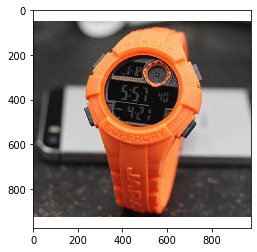

In [11]:
def show_sample(sample):
    data, label = sample
    
    print("Data type: {}".format(data.dtype))
    print("Label: {}".format(label))
    
    plt.imshow(data.asnumpy())
    
show_sample(train_folder[10000])

In [12]:
lr = 0.001
momentum = 0.9
wd = 0.0001
lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

model_name = 'ResNet50_v2'
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

trainer = gluon.Trainer(finetune_net.collect_params(), 'nag', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
# trainer = gluon.Trainer(finetune_net.collect_params(), 'adam', {'learning_rate': 1})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [13]:
def test(net, validation_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(validation_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

In [ ]:
lr_counter = 0
num_batch = len(train_data)

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)
        
        print('[Epoch %d] Batch %d/%d - Loss: %.3f | time: %.1f' % 
              (epoch, i, num_batch, train_loss/(i+1), time.time() - tic), end='\r')

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, validation_acc = test(finetune_net, validation_data, ctx)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Validation-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, validation_acc, time.time() - tic))
#     print('[Epoch %d] Train-acc: %.3f, loss: %.3f | time: %.1f' %
#              (epoch, train_acc, train_loss, time.time() - tic))

# _, test_acc = test(pretrained_net, test_data, ctx)
# print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.432, loss: 2.435 | Validation-acc: 0.556 | time: 146.6
[Epoch 1] Train-acc: 0.536, loss: 1.896 | Validation-acc: 0.614 | time: 145.6
[Epoch 2] Train-acc: 0.584, loss: 1.639 | Validation-acc: 0.632 | time: 146.5
[Epoch 3] Train-acc: 0.604, loss: 1.508 | Validation-acc: 0.660 | time: 145.0
[Epoch 4] Train-acc: 0.632, loss: 1.407 | Validation-acc: 0.674 | time: 132.3
[Epoch 5] Train-acc: 0.643, loss: 1.344 | Validation-acc: 0.686 | time: 73.0
[Epoch 6] Train-acc: 0.655, loss: 1.288 | Validation-acc: 0.691 | time: 126.2
[Epoch 7] Train-acc: 0.659, loss: 1.241 | Validation-acc: 0.698 | time: 147.1
[Epoch 8] Train-acc: 0.673, loss: 1.201 | Validation-acc: 0.705 | time: 93.6


In [ ]:
import datetime
file_name = str(datetime.datetime.now()) + '.params'
finetune_net.save_parameters(file_name)